In [2]:
import pandas as pd
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 25)
Df = pd.read_csv("12Buckets.csv")

In [3]:
Groups = ['Safeties','Corners','InsideBackers','Edge','InteriorDLine','WRs','TEs','InteriorOLine','Tackles','QB','RB','Special']
Df.head()

,Year,Team,Safeties,Corners,InsideBackers,Edge,InteriorDLine,WRs,TEs,InteriorOLine,Tackles,QB,RB,Special,Dead,IR,Prac,Susp,Wins,Playoff Wins,SuperBowl Win
0,2005,cardinals,8.02,3.09,2.08,9.11,1.47,8.76,0.44,15.55,5.49,6.72,0.81,3.03,8.08,0.16,0.09,0.0,5,0,0
1,2006,cardinals,9.22,0.95,2.46,11.08,3.72,11.23,0.81,20.40,3.43,6.87,10.18,1.76,1.18,0.61,0.15,0.0,5,0,0
2,2007,cardinals,8.73,1.48,3.39,11.32,1.64,10.80,0.95,10.49,5.60,8.55,7.57,1.13,2.07,13.01,0.08,0.0,8,0,0
3,2008,cardinals,8.13,2.29,9.81,8.31,3.75,11.07,1.67,11.33,13.31,7.49,7.27,0.80,4.09,0.23,0.32,0.0,9,3,0
4,2009,cardinals,10.10,8.03,10.46,6.54,7.00,14.14,0.66,9.37,8.26,12.29,4.53,2.21,6.92,5.68,0.21,0.0,10,1,0


In [4]:
#Normalize spending percentages to the year each team existed in, allowing for comparison and for reasonable distance calculation
def Normalize(x):
    RetList = []
    for position in Groups:
        dfyear = Df[Df['Year'] == x['Year']]
        val = (x[position] - np.mean(dfyear[position]))/(np.std(dfyear[position]))
        
        RetList.append(val)
    
    return pd.Series(RetList)
    
    
    
Df[Groups] = Df.apply(Normalize, axis = 1)

In [360]:
#Select Team and Year to Analyze
Team = 'texans'
Year = 2018

In [318]:
#Calculate the distance (based on normalized spending percentages) from the team in question to all other teams in the dataset
#This allows us to see which teams are most similar in how they allocate cap space relative to the league in their year
def DistAllTeams(x):
    TotD = 0
    for Position in Groups:
        if ((x['Team'] == Team)|(x['Year'] >= Year)):
            return 100
        Di = (x[Position]-TheTeam[Position])**2
        TotD += Di
    Dist = np.sqrt(TotD)
    return Dist
    
    
    
    
## Specific Team's Distances    
TheTeam = Df[(Df['Team'] == Team)&(Df['Year'] == Year)]

Df['Dist'] = Df.apply(DistAllTeams, axis = 1)

In [335]:
#Check the 5 teams that are most similar to the team in question
Df.sort_values(by = "Dist").head()

,Year,Team,Safeties,Corners,InsideBackers,Edge,InteriorDLine,WRs,TEs,InteriorOLine,Tackles,QB,RB,Special,Dead,IR,Prac,Susp,Wins,Playoff Wins,SuperBowl Win,Dist
147,2017,broncos,-0.275769,1.275990,0.569405,1.748226,-1.193978,1.185370,-0.934975,-0.048269,-0.582677,-1.713965,-0.287445,-0.674031,0.28,17.12,0.00,0.0,5,0,0,2.581396
36,2011,ravens,1.087588,0.674492,0.425132,0.578847,0.365045,0.255663,-1.050098,1.027127,-0.969615,-0.756150,-0.408399,0.412685,3.14,6.98,0.56,0.0,12,2,0,3.152850
392,2007,steelers,0.490220,0.213366,2.186756,0.718514,-0.170756,0.386065,0.562288,1.654959,-0.788202,-0.729340,-0.187249,-0.848400,3.09,10.45,0.07,0.0,10,0,0,3.158269
146,2016,broncos,0.597044,1.330626,0.057845,1.680226,-1.157151,1.450945,0.149442,-1.443006,0.322534,-1.502441,0.639666,-0.710087,9.82,12.54,0.00,0.0,9,0,0,3.257890
35,2010,ravens,0.704172,0.240602,0.103506,0.276714,-0.465091,-0.096207,0.665049,0.002709,-0.391633,-1.002982,-0.014877,0.481461,0.27,6.33,0.33,0.0,12,1,0,3.309145


The teams most similar to the 2018 Texans (that aren't the Texans or in the future) are the 2017 Broncos (5 Wins), the 2011 Ravens (12 Wins), and the 2007 Steelers (10 Wins). 

# Quickly break down a few examples one-by-one

### 2017 Broncos (5 Wins)

In [320]:
TopTeams = Df.sort_values(by = "Dist")[:1]

NextYear = Df[(Df['Team'] == TopTeams.iloc[0,1])&(Df['Year'] == TopTeams.iloc[0,0]+1)]

Result = NextYear.copy()

Groups2 = Groups.copy()
Groups2.extend(['Dead','IR','Prac','Susp','Wins','Playoff Wins'])
for i in range(0,len(Groups2)):
    Position = Groups2[i]
    NewVal = NextYear[Position].values - TopTeams[Position].values
    Result.iloc[0,i+2] = NewVal
    
Result.iloc[0,0] = '2017 to 2018'
Result

,Year,Team,Safeties,Corners,InsideBackers,Edge,InteriorDLine,WRs,TEs,InteriorOLine,Tackles,QB,RB,Special,Dead,IR,Prac,Susp,Wins,Playoff Wins,SuperBowl Win,Dist
148,2017 to 2018,broncos,-0.227726,-0.221059,0.485421,-0.923957,0.176749,-1.961223,-0.427315,0.270024,-0.233475,1.210933,-1.335786,0.568758,0.06,3.84,0.0,0.0,1,0,0,100.0


#### The 2018 Broncos spent considerably less on WRs, Edge Rushers, and RBs, while spending considerably more on their QB, which ultimately only led to a 1-win improvement

In [321]:
TopTeams = Df.sort_values(by = "Dist")[1:2]

NextYear = Df[(Df['Team'] == TopTeams.iloc[0,1])&(Df['Year'] == TopTeams.iloc[0,0]+1)]

Result2 = NextYear.copy()

for i in range(0,len(Groups2)):
    Position = Groups2[i]
    NewVal = NextYear[Position].values - TopTeams[Position].values
    Result2.iloc[0,i+2] = NewVal
    
Result2.iloc[0,0] = str(TopTeams['Year'].values[0]) + " to " +  str(NextYear['Year'].values[0])
Result2

,Year,Team,Safeties,Corners,InsideBackers,Edge,InteriorDLine,WRs,TEs,InteriorOLine,Tackles,QB,RB,Special,Dead,IR,Prac,Susp,Wins,Playoff Wins,SuperBowl Win,Dist
37,2011 to 2012,ravens,0.500458,-0.311136,0.253507,-0.906201,0.684663,-0.264289,-0.602289,-1.629572,0.274676,0.374219,1.181989,-0.764452,6.47,6.74,-0.18,0.0,-2,2,1,3.949323


#### The 2012 Ravens spend much less on Interior Offensive Line and Edge and much more on RB and Interior Defensive Line. The 2012 offseason saw the Ravens lose G Ben Grubbs and DE/NT Cory Redding and drafting future all-pros in Courtney Upshaw and Kelechi Osemele. The Ravens also re-signed RB Ray Rice to a large deal and Interior D-Lineman Haloti Ngata's contract value increased significantly. This ultimately led to fewer regular season wins, but a Super Bowl Win

In [365]:
ChangeFrame = pd.DataFrame()
for j in range(0,11):
    TopTeams = Df.sort_values(by = "Dist")[j:j+1]

    NextYear = Df[(Df['Team'] == TopTeams.iloc[0,1])&(Df['Year'] == TopTeams.iloc[0,0]+1)]

    Result2 = NextYear.copy()

    for i in range(0,len(Groups2)):
        Position = Groups2[i]
        NewVal = NextYear[Position].values - TopTeams[Position].values
        Result2.iloc[0,i+2] = NewVal

    Result2.iloc[0,0] = str(TopTeams['Year'].values[0]) + " to " +  str(NextYear['Year'].values[0])
    ChangeFrame = ChangeFrame.append(Result2)

display(ChangeFrame)
    
X = ChangeFrame.copy()

cor = X.corr()
sns.heatmap(cor, xticklabels=cor.columns,yticklabels=cor.columns)
cor[['Wins','Playoff Wins','SuperBowl Win']]

KeyError: 'Dist'

In [17]:
def DistAllTeams(x, Team, Year):
    TheTeam = Df[(Df['Team'] == Team)&(Df['Year'] == Year)]
    TotD = 0
    if ((x['Team'] == Team)|(x['Year'] >= Year)):
        Dist = 100
    
    else:
        for Position in Groups:
            Di = (x[Position]-TheTeam[Position])**2
            TotD += Di
        Dist = np.sqrt(TotD)
    return Dist

def BasicRecommend(x):
    if (x['Wins'] > 0)&(x['Playoff Wins'] > 0):
        message = "Increase spending in this position"
    
    elif (x['Wins'] < 0)&(x['Playoff Wins'] < 0):
        message = "Decrease spending in this position"
        
    else:
        message = "No clear direction from historical data"
        
    return message
    

def FullComparable(Team, Year):
    ChangeFrame = pd.DataFrame()  
    Groups2 = Groups.copy()
    Groups2.extend(['Dead','IR','Prac','Susp','Wins','Playoff Wins'])
    Df['Dist'] = Df.apply(DistAllTeams, axis = 1, args = (Team, Year))
    
    #Check the 5 teams that are most similar to the team in question
    
    ######
    for l in range(0,11):
        
        TopTeams = Df.sort_values(by = "Dist")[l:l+1]
        NextYear = Df[(Df['Team'] == TopTeams.iloc[0,1])&(Df['Year'] == TopTeams.iloc[0,0]+1)]
        
        Result2 = TopTeams.copy()
        for i in range(0,len(Groups2)):
            Position = Groups2[i]
            NewVal = NextYear[Position].values - TopTeams[Position].values
            Result2.iloc[0,i+2] = NewVal

        Result2.iloc[0,0] = str(TopTeams['Year'].values[0]) + " to " +  str(NextYear['Year'].values[0])

        ChangeFrame = ChangeFrame.append(Result2)

    X = ChangeFrame.copy()
    display(X)
    cor = X.corr(method = "spearman").fillna(0)
    sns.heatmap(cor, xticklabels=cor.columns,yticklabels=cor.columns)
    cor['Recommendation'] = cor.apply(BasicRecommend, axis = 1)
    display(cor[['Wins','Playoff Wins','Recommendation']][0:12])
    



,Year,Team,Safeties,Corners,InsideBackers,Edge,InteriorDLine,WRs,TEs,InteriorOLine,Tackles,QB,RB,Special,Dead,IR,Prac,Susp,Wins,Playoff Wins,SuperBowl Win,Dist
345,2005 to 2006,giants,0.506510,0.313362,0.080013,0.508933,-0.390228,0.588028,-0.076783,-0.691131,-0.523479,1.689041,0.581295,0.027376,1.38,0.00,0.00,0.0,-3,0,0,2.398816
471,2011 to 2012,redskins,-3.251610,0.550169,-0.870270,-0.879186,-0.502219,0.751540,-0.512908,-1.243761,1.621345,0.353328,-0.880633,0.170194,-11.81,6.41,3.61,0.0,5,0,0,2.634087
395,2010 to 2011,steelers,0.360959,0.062239,0.738708,0.596705,0.339081,-0.091256,-0.130629,0.810778,-0.989851,0.984742,0.178913,0.244297,0.66,2.22,-0.22,0.0,0,-3,0,2.756110
120,2005 to 2006,cowboys,0.133087,-0.356733,0.392701,-0.344108,-0.391488,0.908232,-0.305552,0.283573,-0.359111,0.745828,-0.068759,-0.161511,0.09,3.53,0.12,0.0,0,0,0,2.849391
393,2008 to 2009,steelers,-0.984499,0.276431,-0.079770,0.339189,0.343984,-1.056202,0.793401,0.684598,-0.728531,0.245289,0.984579,0.164444,4.05,-1.82,-0.09,0.0,-3,-4,1,2.907612
123,2008 to 2009,cowboys,0.281595,-0.618788,-0.717122,1.053472,-0.160827,1.408644,-0.599891,-0.329019,0.220701,-1.022495,-0.399199,0.238751,13.39,-7.62,-0.02,0.0,2,1,0,3.032433
346,2006 to 2007,giants,-2.687915,0.626119,-0.289496,-0.647396,0.154733,0.292222,0.563130,-0.254298,-0.621482,-0.064610,-2.345072,-0.136085,-0.09,6.95,0.00,0.0,2,4,0,3.122025
121,2006 to 2007,cowboys,0.444992,-0.141691,0.037562,0.083354,0.524210,0.774086,0.157831,0.304079,0.768563,0.934078,-0.205544,0.421707,-2.57,-3.53,0.02,0.0,4,1,0,3.147699
428,2013 to 2014,seahawks,1.490412,0.460073,-0.174409,-0.982330,0.737741,-1.988360,-2.191406,0.357476,-1.287283,-0.162847,-0.084606,0.745002,0.48,0.34,-6.73,0.0,-1,1,0,3.151556
124,2009 to 2010,cowboys,-1.706702,1.821917,0.017989,0.395875,0.203742,1.342127,0.208976,0.281808,1.663188,1.960999,1.856217,-0.335590,3.35,2.14,0.08,0.0,-5,-1,0,3.215459


,Wins,Playoff Wins,Recommendation
Safeties,-0.235046,0.145619,No clear direction from historical data
Corners,-0.230437,0.000000,No clear direction from historical data
InsideBackers,-0.350264,-0.441553,Decrease spending in this position
Edge,-0.225828,-0.342908,Decrease spending in this position
InteriorDLine,-0.230437,0.046974,No clear direction from historical data
WRs,0.248872,0.187895,Increase spending in this position
TEs,-0.262698,-0.281842,Decrease spending in this position
InteriorOLine,-0.281133,-0.286540,Decrease spending in this position
Tackles,0.285742,0.037579,Increase spending in this position
QB,-0.377916,-0.516711,Decrease spending in this position


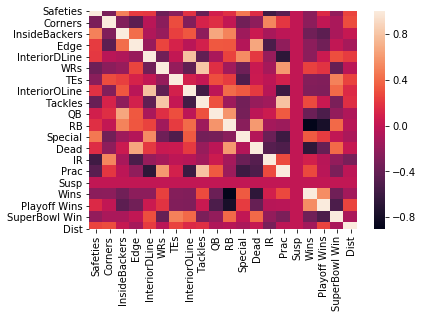

In [19]:
FullComparable('chiefs',2018)